In [11]:
import sys
import os
import numpy as np
import multiprocessing
import dill
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.api import OLS, add_constant
import time
from scipy.stats import norm

from vax_sims_LHS_samples import *
from plot_utils import *
# from util_functions import *
# from uncertainty_analysis import *
# from sim_helper_functions import *

In [12]:
base_folders = [
    'oct_6_posterior_sims_test_frequencies_1633556966/policy_1/',
    'oct_6_posterior_sims_test_frequencies_1633556966/policy_2/',
    'oct_6_posterior_sims_test_frequencies_1633557121/policy_3/',
    'oct_6_posterior_sims_test_frequencies_1633557121/policy_4/',
    'oct_6_posterior_sims_test_frequencies_1633557424/policy_5/',
    'oct_6_posterior_sims_test_frequencies_1633557424/policy_6/',
    'oct_6_posterior_sims_test_frequencies_1633557424/policy_7/'
]

vax_subfolder_names = ['vax_rates_0/', 'vax_rates_1/', 'vax_rates_2/', 'vax_rates_3/']

In [19]:
def load_sim_output(folder, npoints, lb=0):
    scenario_data = pd.DataFrame(columns=UNCERTAINTY_PARAMS+['student_inf_10','student_inf_50','student_inf_90']+\
                                ['staff_inf_10', 'staff_inf_50', 'staff_inf_90'])
    for idx in range(lb, npoints):
        inf_file = folder + '/list_of_infs_by_group_{}.dill'.format(idx)
        point_file = folder + '/lhs_point_{}.dill'.format(idx)
        if not os.path.isfile(inf_file):
            continue
        with open(inf_file, 'rb') as fhandle:
            inf_matrix = np.array(dill.load(fhandle))
            student_infxns = np.sum(inf_matrix[:,:-2], axis=1)
            staff_infxns = np.sum(inf_matrix[:,-2:], axis=1)
        with open(point_file, 'rb') as fhandle:
            uncertainty_point = dill.load(fhandle)

        new_row = dict()
        for index, col_name in enumerate(UNCERTAINTY_PARAMS):
            if type(uncertainty_point) == dict:
                new_row[col_name] = uncertainty_point[col_name]
            else:
                new_row[col_name] = uncertainty_point[index]
        new_row['student_inf_10'] = np.quantile(student_infxns, 0.1)
        new_row['student_inf_50'] = np.quantile(student_infxns, 0.5)
        new_row['student_inf_90'] = np.quantile(student_infxns, 0.9)
        new_row['staff_inf_10'] = np.quantile(staff_infxns, 0.1)
        new_row['staff_inf_50'] = np.quantile(staff_infxns, 0.5)
        new_row['staff_inf_90'] = np.quantile(staff_infxns, 0.9)
        new_row['cornell_inf_10'] = np.quantile(student_infxns + staff_infxns, 0.1)
        new_row['cornell_inf_50'] = np.quantile(student_infxns + staff_infxns, 0.5)
        new_row['cornell_inf_90'] = np.quantile(student_infxns + staff_infxns, 0.9)
        
        scenario_data = scenario_data.append(new_row, ignore_index=True)

    return scenario_data

In [20]:
base_folder_idx, vax_rate_idx

(1, 1)

In [23]:
sim_data = {}
for base_folder_idx in range(len(base_folders)):
    for vax_rate_idx in range(len(vax_subfolder_names)):
        sim_data[base_folder_idx, vax_rate_idx] = \
        load_sim_output(base_folders[base_folder_idx] + vax_subfolder_names[vax_rate_idx], 106, lb=1)
        print("for policy {} and vax rate {}, loaded {} data points".format(
        base_folder_idx+1, vax_rate_idx, sim_data[base_folder_idx, vax_rate_idx].shape[0]))



for policy 1 and vax rate 0, loaded 105 data points
for policy 1 and vax rate 1, loaded 105 data points
for policy 1 and vax rate 2, loaded 105 data points
for policy 1 and vax rate 3, loaded 105 data points
for policy 2 and vax rate 0, loaded 105 data points
for policy 2 and vax rate 1, loaded 22 data points
for policy 2 and vax rate 2, loaded 0 data points
for policy 2 and vax rate 3, loaded 0 data points
for policy 3 and vax rate 0, loaded 105 data points
for policy 3 and vax rate 1, loaded 105 data points
for policy 3 and vax rate 2, loaded 105 data points
for policy 3 and vax rate 3, loaded 105 data points
for policy 4 and vax rate 0, loaded 105 data points
for policy 4 and vax rate 1, loaded 105 data points
for policy 4 and vax rate 2, loaded 105 data points
for policy 4 and vax rate 3, loaded 105 data points
for policy 5 and vax rate 0, loaded 105 data points
for policy 5 and vax rate 1, loaded 105 data points
for policy 5 and vax rate 2, loaded 105 data points
for policy 5 and 

In [53]:
import pandas as pd
posterior_df = pd.read_csv("posterior_csvs/test_frequency_vax_sims_posterior.csv")
posterior_df['normalized_posterior'] = posterior_df['posterior'] / posterior_df['posterior'].sum()

def posterior_weighted_stats(scenario_data):
    weighted_median_infs = []
    for idx in range(scenario_data.shape[0]):
        median_infs = scenario_data['student_inf_50'].iloc[idx]
        weight = posterior_df['normalized_posterior'].iloc[idx]
        weighted_median_infs.append((median_infs, weight))

    sorted_weighted_median_infs = sorted(weighted_median_infs, key=lambda x: x[0])
    p10_idx = -1 # want cumulative_posterior(p10_idx) < 0.1 and cumulative_posterior(p10_idx+1) >= 0.1
    p50_idx = -1 # same as above but with 0.5
    p90_idx = -1 # cum_posterior(p90_dx - 1) < 0.9 and cum_posterior(p90_idx) >= 0.9

    cum_weight = 0
    for idx in range(len(sorted_weighted_median_infs)):
        median_infs, weight = sorted_weighted_median_infs[idx]

        prev_cum_weight = cum_weight
        cum_weight += weight

        if cum_weight >= 0.1 and prev_cum_weight < 0.1:
            p10_idx = idx - 1

        if cum_weight >= 0.5 and prev_cum_weight < 0.5:
            p50_idx = idx - 1

        if cum_weight >= 0.9 and prev_cum_weight < 0.9:
            p90_idx = idx 

    p10_val = sorted_weighted_median_infs[p10_idx][0]
    p50_val = sorted_weighted_median_infs[p50_idx][0]
    p90_val = sorted_weighted_median_infs[p90_idx][0]

    return p10_val, p50_val, p90_val
        

In [54]:
policy_labels = {1: '0x/week vax, 1x/week unvax',
                2: '0x/week vax, 2x/week unvax',
                3: '1x/week vax, 1x/week unvax',
                4: '1x/week vax, 2x/week unvax',
                5: '2x/week vax, 2x/week unvax', 
                6: '1x/week others, 2x/week greek, unvax',
                7: '3x/week greek, 2x/week unvax, 1x/week vax',
                8: 'No testing'}

fully_simulated_policies = [1, 3, 4, 5, 6]
median_inf_10 = {policy_idx: [] for policy_idx in fully_simulated_policies}
median_inf_50 = {policy_idx: [] for policy_idx in fully_simulated_policies}
median_inf_90 = {policy_idx: [] for policy_idx in fully_simulated_policies}

for policy_idx in fully_simulated_policies:
    base_folder_idx = policy_idx - 1
    for vax_rate_idx in range(4):
        scenario_data = sim_data[base_folder_idx, vax_rate_idx]
        p10_val, p50_val, p90_val = posterior_weighted_stats(scenario_data)
        median_inf_10[policy_idx].append(p10_val)
        median_inf_50[policy_idx].append(p50_val)
        median_inf_90[policy_idx].append(p90_val)

In [58]:
purple_policy = 5
black_policy = 6

black_99_vax_scenario = sim_data[black_policy-1, 3]
black_75_vax_scenario = sim_data[black_policy-1, 2]

In [67]:
median_inf_50[black_policy]

[4141.0, 2691.0, 347.5, 624.0]

In [68]:
median_inf_50[purple_policy]

[4192.0, 2563.5, 359.5, 617.0]

In [64]:
black_99_vax_scenario['student_inf_50'] - black_75_vax_scenario['student_inf_50']

0       377.0
1     -1159.0
2       365.0
3       369.0
4       238.5
        ...  
100    -180.0
101     245.0
102     272.0
103     189.5
104     300.0
Name: student_inf_50, Length: 105, dtype: float64

In [65]:
black_99_vax_scenario.iloc[0]

vax_susc_mult                          0.494898
vax_transmission_mult                  0.643708
contacts_per_day_mult                  1.165605
outside_infection_rate_mult            1.500197
cases_isolated_per_contact_trace       1.175453
student_inf_10                       298.800000
student_inf_50                       730.000000
student_inf_90                      1350.200000
staff_inf_10                         416.600000
staff_inf_50                         637.000000
staff_inf_90                         956.100000
cornell_inf_10                       945.700000
cornell_inf_50                      1330.500000
cornell_inf_90                      1878.600000
Name: 0, dtype: float64

In [66]:
black_75_vax_scenario.iloc[0]

vax_susc_mult                          0.494898
vax_transmission_mult                  0.643708
contacts_per_day_mult                  1.165605
outside_infection_rate_mult            1.500197
cases_isolated_per_contact_trace       1.175453
student_inf_10                       155.900000
student_inf_50                       353.000000
student_inf_90                       720.800000
staff_inf_10                         410.800000
staff_inf_50                         526.500000
staff_inf_90                         625.900000
cornell_inf_10                       666.500000
cornell_inf_50                       894.000000
cornell_inf_90                      1315.100000
Name: 0, dtype: float64

In [63]:
num_where_75_worse_than_99 = 0
num_where_99_worse_than_75 = 0
for idx, difference in enumerate(black_99_vax_scenario['student_inf_50'] - black_75_vax_scenario['student_inf_50']):
    if difference > 0:
        print(idx, difference)
        
        if difference > 0:
            num_where_99_worse_than_75 += 1
        else:
            num_where_75_worse_than_99 += 1

print(num_where_99_worse_than_75)

0 377.0
2 365.0
3 369.0
4 238.5
5 339.0
6 451.5
8 494.5
9 238.0
10 420.0
11 222.5
12 515.0
14 318.0
15 375.5
16 70.5
19 290.5
20 250.0
21 158.0
23 362.5
24 80.5
25 52.0
27 254.5
28 350.0
29 172.5
30 215.0
34 230.0
36 327.5
37 68.0
39 297.0
40 471.5
41 116.0
42 182.5
44 410.5
45 198.5
46 517.0
48 544.0
50 302.5
52 205.5
53 381.0
54 114.0
56 429.5
57 118.0
60 7.0
61 130.5
63 278.0
64 350.0
67 280.0
68 451.5
69 289.0
71 395.5
72 319.5
75 240.0
76 333.0
77 481.5
84 133.0
85 98.5
88 205.5
90 292.0
91 68.0
92 265.5
93 271.5
94 228.5
96 417.0
99 290.0
101 245.0
102 272.0
103 189.5
104 300.0
67


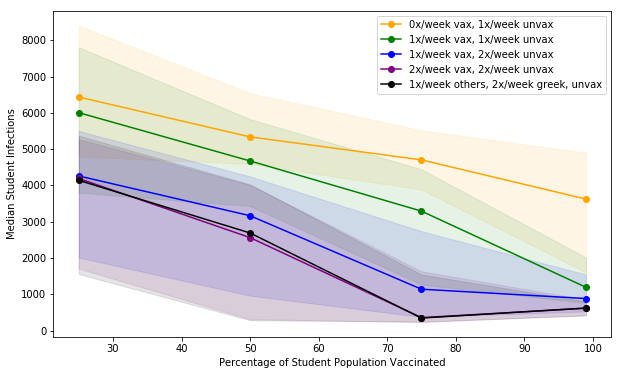

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,6))

vax_rates_x = [25, 50, 75, 99]
colours = ['orange', 'green', 'blue', 'purple', 'black']

for policy_idx, colour in zip(fully_simulated_policies, colours):
    plt.plot(vax_rates_x, median_inf_50[policy_idx], color=colour, 
             marker='o', label=policy_labels[policy_idx])
    plt.fill_between(vax_rates_x, 
                     y1=median_inf_10[policy_idx], 
                     y2=median_inf_90[policy_idx],
                     color=colour, alpha=0.1)

plt.xlabel("Percentage of Student Population Vaccinated")
plt.ylabel("Median Student Infections")
plt.legend()
plt.show()

In [24]:
scenario_data = sim_data[0,0]

In [25]:
scenario_data.shape

(105, 14)

In [ ]:
for base_folder_idx, 

In [32]:
scenario_data['student_inf_10'].median()

6378.3

In [57]:
import multiprocessing
multiprocessing.cpu_count()

80